In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from pandas.tseries import converter
converter.register()
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

In [2]:
DATA_DIR = os.path.join('.', 'data')

In [3]:
data_paths = {'train': os.path.join(DATA_DIR, 'train.csv'), 
              'metadata':  os.path.join(DATA_DIR, 'metadata.csv'),
              'weather':  os.path.join(DATA_DIR, 'weather.csv'),
              'holidays':  os.path.join(DATA_DIR, 'holidays.csv'),
              'submission_format':  os.path.join(DATA_DIR, 'submission_format.csv')}

In [4]:
train_test = pd.read_csv(data_paths['train'], nrows=100)
float_cols = [c for c in train_test if train_test[c].dtype == "float64"]
float32_cols = {c: np.float32 for c in float_cols}

In [5]:
train_test = pd.read_csv(data_paths['train'],nrows=100)
float_cols = [c for c in train_test if train_test[c].dtype == "float64"]
float32_cols = {c: np.float32 for c in float_cols}
train = pd.read_csv(data_paths['train'], engine='c',dtype=float32_cols)

train['meter_id'] = train['meter_id'].apply(str)
train['Timestamp'] = pd.to_datetime(train['Timestamp'])
train['Date'] = train.Timestamp.apply(lambda x: x.date())
train['Date'] = train['Date'].astype('<M8[ns]')
train['DayOfWeek'] = train['Date'].dt.weekday_name
train.rename({'Unnamed: 0':'obs_id'}, axis='columns', inplace=True)

In [8]:
metadata = pd.read_csv(data_paths['metadata'])
metadata.head()

,meter_id,site_id,meter_description,units,surface,activity
0,234_203,234_203,virtual main,Wh,5750.0,office
1,863,234_203,main meter,Wh,5750.0,office
2,869,234_203,other,Wh,5750.0,office
3,872,234_203,elevators,Wh,5750.0,office
4,875,234_203,Lighting,Wh,5750.0,office


In [10]:
weather = pd.read_csv(data_paths['weather'], index_col=0)
weather['Timestamp'] = pd.to_datetime(weather['Timestamp'])
weather.loc[weather.site_id=='38','site_id'] = '038'

In [11]:
weather.head()

,Timestamp,Temperature,Distance,site_id
42628,2012-01-01 01:00:00,3.9,11.902932,038
42629,2012-01-01 02:00:00,4.1,11.902932,038
42630,2012-01-01 03:00:00,4.2,11.902932,038
42631,2012-01-01 04:00:00,4.1,11.902932,038
42632,2012-01-01 05:00:00,4.3,11.902932,038


In [12]:
holidays = pd.read_csv(data_paths['holidays'], index_col=0)
holidays['Date'] = pd.to_datetime(holidays['Date'])
holidays = holidays.groupby(['Date','site_id']).min().reset_index()

In [13]:
holidays.head()

,Date,site_id,Holiday
0,2010-01-01,038,New year
1,2010-01-01,334_61,New year
2,2010-01-06,334_61,Epiphany
3,2010-02-15,334_61,Clean Monday
4,2010-03-25,334_61,Annunciation


In [14]:
submission_format = pd.read_csv(data_paths['submission_format'], index_col=0)

In [15]:
train.head()

,obs_id,meter_id,Timestamp,Values,Date,DayOfWeek
0,2532,2,2015-06-11 00:00:00,2035.0,2015-06-11,Thursday
1,2543,2,2015-06-11 00:15:00,2074.0,2015-06-11,Thursday
2,2544,2,2015-06-11 00:30:00,2062.0,2015-06-11,Thursday
3,2525,2,2015-06-11 00:45:00,2025.0,2015-06-11,Thursday
4,2534,2,2015-06-11 01:00:00,2034.0,2015-06-11,Thursday


In [16]:
metadata.head()

,meter_id,site_id,meter_description,units,surface,activity
0,234_203,234_203,virtual main,Wh,5750.0,office
1,863,234_203,main meter,Wh,5750.0,office
2,869,234_203,other,Wh,5750.0,office
3,872,234_203,elevators,Wh,5750.0,office
4,875,234_203,Lighting,Wh,5750.0,office


In [17]:
holidays.head()

,Date,site_id,Holiday
0,2010-01-01,038,New year
1,2010-01-01,334_61,New year
2,2010-01-06,334_61,Epiphany
3,2010-02-15,334_61,Clean Monday
4,2010-03-25,334_61,Annunciation


In [18]:
weather.head()

,Timestamp,Temperature,Distance,site_id
42628,2012-01-01 01:00:00,3.9,11.902932,038
42629,2012-01-01 02:00:00,4.1,11.902932,038
42630,2012-01-01 03:00:00,4.2,11.902932,038
42631,2012-01-01 04:00:00,4.1,11.902932,038
42632,2012-01-01 05:00:00,4.3,11.902932,038


In [19]:
submission_format.head()

,meter_id,Timestamp,is_abnormal
obs_id,,,
171227,234_203,2013-11-03 19:00:00,False
177020,234_203,2013-11-03 19:30:00,False
165375,234_203,2013-11-03 20:00:00,False
207176,234_203,2013-11-03 20:30:00,False
353253,234_203,2013-11-03 21:00:00,False


In [20]:
train_metadata = pd.merge(train, metadata, left_on="meter_id", right_on="meter_id",how='left')

In [21]:
train_metadata['divisor'] = 1.0
train_metadata.loc[train_metadata.units=='Wh','divisor']  = 1000.0

In [22]:
train_metadata.Values = train_metadata.Values/ train_metadata.divisor

In [23]:
train_metadata.loc[train_metadata.units=='Wh', 'units']= 'kWh'

In [24]:
train_metadata_holidays = pd.merge(train_metadata, holidays,\
                                   left_on=["Date","site_id"],\
                                   right_on=["Date","site_id"],\
                                   how='left',suffixes=["","_holidays"])

In [25]:
train_metadata_holidays.head()

,obs_id,meter_id,Timestamp,Values,Date,DayOfWeek,site_id,meter_description,units,surface,activity,divisor,Holiday
0,2532,2,2015-06-11 00:00:00,2.035,2015-06-11,Thursday,334_61,main meter,kWh,2000.0,office,1000.0,NaN
1,2543,2,2015-06-11 00:15:00,2.074,2015-06-11,Thursday,334_61,main meter,kWh,2000.0,office,1000.0,NaN
2,2544,2,2015-06-11 00:30:00,2.062,2015-06-11,Thursday,334_61,main meter,kWh,2000.0,office,1000.0,NaN
3,2525,2,2015-06-11 00:45:00,2.025,2015-06-11,Thursday,334_61,main meter,kWh,2000.0,office,1000.0,NaN
4,2534,2,2015-06-11 01:00:00,2.034,2015-06-11,Thursday,334_61,main meter,kWh,2000.0,office,1000.0,NaN


In [26]:
train_metadata_holidays.loc[train_metadata_holidays.Holiday.notnull(),'isHoliday'] = 1
train_metadata_holidays.loc[train_metadata_holidays.Holiday.isnull(),'isHoliday'] = 0

In [27]:
train_metadata_holidays[train_metadata_holidays.isHoliday == 1].head()

,obs_id,meter_id,Timestamp,Values,Date,DayOfWeek,site_id,meter_description,units,surface,activity,divisor,Holiday,isHoliday
6240,8768,2,2015-08-15 00:00:00,2.833,2015-08-15,Saturday,334_61,main meter,kWh,2000.0,office,1000.0,Assumption of Mary to Heaven,1.0
6241,8745,2,2015-08-15 00:15:00,2.762,2015-08-15,Saturday,334_61,main meter,kWh,2000.0,office,1000.0,Assumption of Mary to Heaven,1.0
6242,8739,2,2015-08-15 00:30:00,2.743,2015-08-15,Saturday,334_61,main meter,kWh,2000.0,office,1000.0,Assumption of Mary to Heaven,1.0
6243,8738,2,2015-08-15 00:45:00,2.746,2015-08-15,Saturday,334_61,main meter,kWh,2000.0,office,1000.0,Assumption of Mary to Heaven,1.0
6244,8756,2,2015-08-15 01:00:00,2.787,2015-08-15,Saturday,334_61,main meter,kWh,2000.0,office,1000.0,Assumption of Mary to Heaven,1.0


In [28]:
train_metadata_holidays['ValuesShifted'] = train_metadata_holidays['Values'].shift(1)
train_metadata_holidays['ValuesDifferential'] = train_metadata_holidays['Values']-train_metadata_holidays['ValuesShifted']
#These turning points are missing from the final output, so setting them to NaN instead
train_metadata_holidays.loc[train_metadata_holidays.ValuesDifferential<0,'ValuesDifferential'] = np.nan#train_metadata_holidays.Values

In [29]:
train_metadata_holidays['isHolidayTomorrow'] = train_metadata_holidays['isHoliday'].shift(-1)
train_metadata_holidays['isHolidayYesterday'] = train_metadata_holidays['isHoliday'].shift(1)

In [30]:
submission_format.meter_id.drop_duplicates()

obs_id
171227    234_203
93325      334_61
198212    38_9686
Name: meter_id, dtype: object

In [31]:
site_id_one = train_metadata_holidays[train_metadata_holidays.meter_id=='234_203']['site_id'].drop_duplicates().values[0]
site_id_two = train_metadata_holidays[train_metadata_holidays.meter_id=='334_61']['site_id'].drop_duplicates().values[0]
site_id_three = train_metadata_holidays[train_metadata_holidays.meter_id=='38_9686']['site_id'].drop_duplicates().values[0]

In [32]:
site_one = train_metadata_holidays[(train_metadata_holidays.site_id==site_id_one) &\
                                   ((train_metadata_holidays.meter_id=='234_203'))]

In [33]:
site_two = train_metadata_holidays[(train_metadata_holidays.site_id==site_id_two) &\
                                   ((train_metadata_holidays.meter_id=='334_61'))]

In [34]:
site_three = train_metadata_holidays[(train_metadata_holidays.site_id==site_id_three) &\
                                   ((train_metadata_holidays.meter_id=='38_9686'))]

In [35]:
site_one_meters = train_metadata_holidays[(train_metadata_holidays.site_id==site_id_one)].meter_id.drop_duplicates().values
for meter_id in site_one_meters:
    df = train_metadata_holidays[(train_metadata_holidays.meter_id==meter_id)][['Timestamp','Values']]
    site_one = pd.merge_asof(site_one, df,\
                                   left_on=["Timestamp"],\
                                   right_on=["Timestamp"],\
                                   suffixes=["","_" + meter_id])
    site_one['Values_' + meter_id] = site_one['Values_' + meter_id].shift(-1)
    site_one['Median_' + meter_id] = pd.rolling_mean(site_one['Values_' + meter_id],window = 10, min_periods=1)
site_one=site_one.dropna(axis=1,how='all')  

In [36]:
site_one = site_one.drop(['ValuesDifferential','ValuesShifted'],axis=1)
site_one=site_one.dropna(axis=1,how='all')   

In [37]:
site_two_meters = train_metadata_holidays[(train_metadata_holidays.site_id==site_id_two)].meter_id.drop_duplicates().values
for meter_id in site_two_meters:
    df = train_metadata_holidays[(train_metadata_holidays.meter_id==meter_id)][['Timestamp','Values']]
    site_two = pd.merge_asof(site_two, df,\
                                   left_on=["Timestamp"],\
                                   right_on=["Timestamp"],\
                                   suffixes=["","_" + meter_id])
    site_two['Values_' + meter_id] = site_two['Values_' + meter_id].shift(-1)
    site_two['Median_' + meter_id] = pd.rolling_mean(site_two['Values_' + meter_id],window = 10, min_periods=1)

In [38]:
site_two = site_two.drop(['ValuesDifferential','ValuesShifted'],axis=1)
site_two=site_two.dropna(axis=1,how='all') 

In [39]:
site_three_meters = train_metadata_holidays[(train_metadata_holidays.site_id==site_id_three)].meter_id.drop_duplicates().values
for meter_id in site_three_meters:
    df = train_metadata_holidays[(train_metadata_holidays.meter_id==meter_id)][['Timestamp','Values']]
    site_three = pd.merge_asof(site_three, df,\
                                   left_on=["Timestamp"],\
                                   right_on=["Timestamp"],\
                                   suffixes=["","_" + meter_id])
    site_three['Values_' + meter_id] = site_three['Values_' + meter_id].shift(-1)
    site_three['Median_' + meter_id] = pd.rolling_mean(site_three['Values_' + meter_id],window = 10, min_periods=1)
site_three.Values = site_three.ValuesDifferential    

In [40]:
site_three=site_three.dropna(axis=1,how='all') 
site_three.Values = site_three.ValuesDifferential    

In [41]:
site_three = site_three.drop(['ValuesDifferential','ValuesShifted'],axis=1)

In [42]:
weather_site_one = weather[(weather.site_id==site_id_one)]
weather_site_one.Distance = weather_site_one.Distance.astype(str)
distances = list(weather_site_one.Distance.drop_duplicates().values)
distances.sort(key=lambda x: float(x))
min_distance = distances[0]
weather_site_one.Distance = weather_site_one.Distance
weather_site_one = weather_site_one.pivot_table(index='Timestamp',columns='Distance',values='Temperature').reset_index()

for distance in distances[1:]:
    weather_site_one[min_distance].fillna(weather_site_one[distance], inplace=True)
    
weather_site_one['Temperature'] = weather_site_one[min_distance]
weather_site_one.drop(columns=distances,inplace=True)
weather_site_one = weather_site_one.set_index('Timestamp').reindex(site_one.set_index('Timestamp').index, method=None).reset_index()
weather_site_one['month'] = weather_site_one.Timestamp.dt.month
weather_site_one['day'] = weather_site_one.Timestamp.dt.day
weather_site_one['hour'] = weather_site_one.Timestamp.dt.hour
weather_site_one['minute'] = weather_site_one.Timestamp.dt.minute
weather_site_one_median = weather_site_one.groupby(['month','day','hour','minute']).median().reset_index()
weather_site_one = pd.merge(weather_site_one,weather_site_one_median,\
                left_on = ['month','day','hour','minute'], \
                right_on = ['month','day','hour','minute'],
                suffixes = ['','_median'])
weather_site_one.Temperature = weather_site_one.Temperature.fillna(weather_site_one.Temperature_median)
weather_site_one.drop(columns=['month','day','hour','minute','Temperature_median'],inplace = True, axis = 1)
weather_site_one = weather_site_one.sort_values(by=['Timestamp'])

In [43]:
weather_site_two = weather[(weather.site_id==site_id_two)]
weather_site_two.Distance = weather_site_two.Distance.astype(str)
distances = list(weather_site_two.Distance.drop_duplicates().values)
distances.sort(key=lambda x: float(x))
min_distance = distances[0]
weather_site_two.Distance = weather_site_two.Distance
weather_site_two = weather_site_two.pivot_table(index='Timestamp',columns='Distance',values='Temperature').reset_index()

for distance in distances[1:]:
    weather_site_two[min_distance].fillna(weather_site_two[distance], inplace=True)
    
weather_site_two['Temperature'] = weather_site_two[min_distance]
weather_site_two.drop(columns=distances,inplace=True)

weather_site_two['month'] = weather_site_two.Timestamp.dt.month
weather_site_two['day'] = weather_site_two.Timestamp.dt.day
weather_site_two['hour'] = weather_site_two.Timestamp.dt.hour
weather_site_two['minute'] = weather_site_two.Timestamp.dt.minute
weather_site_two_median = weather_site_two.groupby(['month','day','hour','minute']).median().reset_index()
weather_site_two = weather_site_two.set_index('Timestamp').reindex(site_two.set_index('Timestamp').index, method=None).reset_index()
weather_site_two = pd.merge(weather_site_two,weather_site_two_median,\
                left_on = ['month','day','hour','minute'], \
                right_on = ['month','day','hour','minute'],
                suffixes = ['','_median'])
weather_site_two.Temperature = weather_site_two.Temperature.fillna(weather_site_two.Temperature_median)
weather_site_two.drop(columns=['month','day','hour','minute','Temperature_median'],inplace = True, axis = 1)
weather_site_two = weather_site_two.sort_values(by=['Timestamp'])

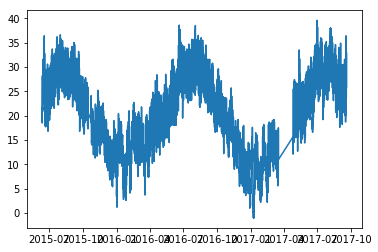

In [44]:
plt.plot(weather_site_two['Timestamp'], weather_site_two['Temperature'])

In [45]:
site_three_local_weather = train_metadata_holidays[(train_metadata_holidays.site_id==site_id_three) &\
                        (train_metadata_holidays.meter_id=='38_0')][['Timestamp','Values','site_id']]
site_three_local_weather.rename({'Values':'Temperature'}, axis=1, inplace=True)
site_three_local_weather['Distance'] = 0.0
site_three_local_weather = site_three_local_weather.reindex(columns=weather.columns)
#site_three_local_weather = site_three_local_weather[site_three_local_weather.Temperature.notnull()]

weather_site_three = pd.concat([weather[(weather.site_id==site_id_three)],site_three_local_weather])
#weather_site_three = weather[(weather.site_id==site_id_three)]
weather_site_three.Distance = weather_site_three.Distance.astype(str)
distances = list(weather_site_three.Distance.drop_duplicates().values)
distances.sort(key=lambda x: float(x))
min_distance = distances[0]
weather_site_three.Distance = weather_site_three.Distance
weather_site_three = weather_site_three.pivot_table(index='Timestamp',columns='Distance',values='Temperature').reset_index()

for distance in distances[1:]:
    weather_site_three[min_distance].fillna(weather_site_three[distance], inplace=True)
    
weather_site_three['Temperature'] = weather_site_three[min_distance]
weather_site_three.drop(columns=distances,inplace=True)

weather_site_three['month'] = weather_site_three.Timestamp.dt.month
weather_site_three['day'] = weather_site_three.Timestamp.dt.day
weather_site_three['hour'] = weather_site_three.Timestamp.dt.hour
weather_site_three['minute'] = weather_site_three.Timestamp.dt.minute
weather_site_three_median = weather_site_three.groupby(['month','day','hour','minute']).median().reset_index()
weather_site_three = weather_site_three.set_index('Timestamp').reindex(weather_site_three.set_index('Timestamp').index, method=None).reset_index()
weather_site_three = pd.merge(weather_site_three,weather_site_three_median,\
                left_on = ['month','day','hour','minute'], \
                right_on = ['month','day','hour','minute'],
                suffixes = ['','_median'])
weather_site_three.Temperature = weather_site_three.Temperature.fillna(weather_site_three.Temperature_median)
weather_site_three.drop(columns=['month','day','hour','minute','Temperature_median'],inplace = True, axis = 1)
weather_site_three = weather_site_three.sort_values(by=['Timestamp'])
weather_site_three = weather_site_three.dropna()

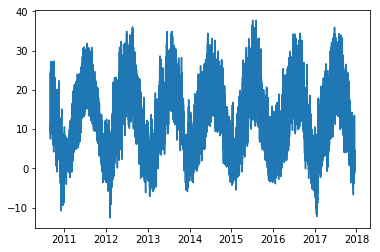

In [46]:
plt.plot(weather_site_three['Timestamp'], weather_site_three['Temperature'])

In [47]:
site_three_temp_sensors = metadata[(metadata.site_id=='038') & (metadata.meter_description=='temperature')]['meter_id'].values

In [48]:
site_one_combined = pd.merge(site_one, weather_site_one, left_on="Timestamp", right_on="Timestamp")

In [49]:
site_two_combined = pd.merge_asof(site_two, weather_site_two, left_on="Timestamp", right_on="Timestamp")

In [50]:
site_three_combined = pd.merge_asof(site_three, weather_site_three, left_on="Timestamp", right_on="Timestamp")

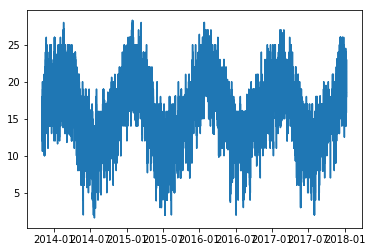

In [51]:
plt.plot(site_one_combined['Timestamp'], site_one_combined['Temperature'])

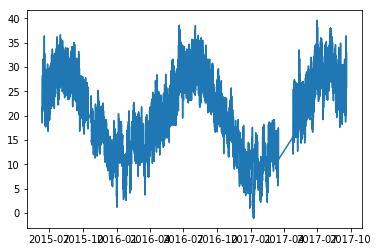

In [52]:
plt.plot(site_two_combined['Timestamp'], site_two_combined['Temperature'])

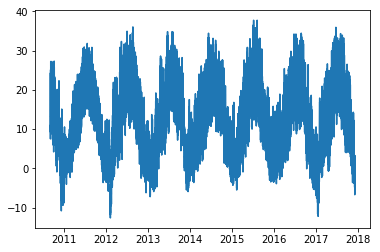

In [53]:
plt.plot(site_three_combined['Timestamp'], site_three_combined['Temperature'])

In [54]:
site_three_temp_sensors_filtered = list(filter(lambda x: 'Values_' + x in site_three_combined.columns,site_three_temp_sensors))

In [55]:
for temp_sensor in site_three_temp_sensors_filtered:    
    column_name = 'Values_' + temp_sensor
    site_three_combined[column_name+'_delta'] = site_three_combined[column_name] - site_three_combined.Temperature

In [57]:
site_one_combined.to_parquet("./data/site_one.parquet")

In [58]:
site_two_combined.to_parquet("./data/site_two.parquet")

In [59]:
site_three_combined.to_parquet("./data/site_three.parquet")

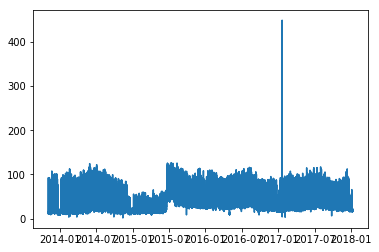

In [60]:
plt.plot(site_one_combined['Timestamp'], site_one_combined['Values'])

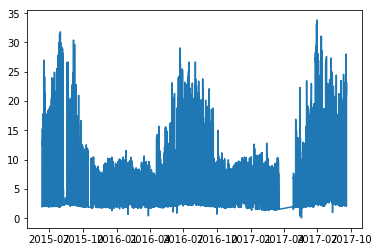

In [61]:
plt.plot(site_two_combined['Timestamp'], site_two_combined['Values'])

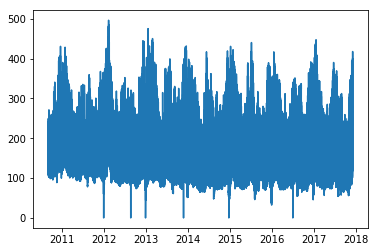

In [62]:
plt.plot(site_three_combined['Timestamp'], site_three_combined['Values'])